In [1]:
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import KNNGraph
import torch_geometric.transforms as T
import process_3dm_file
import nyc_dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Change this variable to configure the 'density' of the point cloud.
# SAMPLES refers to the number of vertices.
SAMPLES = 32768
data_list = process_3dm_file.get_all_models_from_json(samples=SAMPLES)

dataset = nyc_dataset.NYCDataset(data_list)

dataset.transform = T.Compose([KNNGraph(k=6)])


Loading vertices from file: NYC_3DModel_BK01.json
Loading vertices from file: NYC_3DModel_BK02.json
Loading vertices from file: NYC_3DModel_BK03.json
Loading vertices from file: NYC_3DModel_BK04.json
Loading vertices from file: NYC_3DModel_BK05.json
Loading vertices from file: NYC_3DModel_BK06.json
Loading vertices from file: NYC_3DModel_BK07.json
Loading vertices from file: NYC_3DModel_BK08.json
Loading vertices from file: NYC_3DModel_BK09.json
Loading vertices from file: NYC_3DModel_BK10.json
Loading vertices from file: NYC_3DModel_BK11.json
Loading vertices from file: NYC_3DModel_BK12.json
Loading vertices from file: NYC_3DModel_BK13.json
Loading vertices from file: NYC_3DModel_BK14.json
Loading vertices from file: NYC_3DModel_BK15.json
Loading vertices from file: NYC_3DModel_BK16.json
Loading vertices from file: NYC_3DModel_BK17.json
Loading vertices from file: NYC_3DModel_BK18.json
Loading vertices from file: NYC_3DModel_BX01.json
Loading vertices from file: NYC_3DModel_BX02.json


In [2]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

def get_by_class(class_name):
    return [data for data in dataset if data.y == class_name]

train_dataset = []
test_dataset = []

for i in range(5):
    list = get_by_class(i)
    train_list, test_list = split_list(list)
    train_dataset += train_list
    test_dataset += test_list

In [3]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [4]:
import torch
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU

from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden
        # node dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(
            Linear(in_channels + 3, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self,
        h: Tensor,
        pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self,
        h_j: Tensor,
        pos_j: Tensor,
        pos_i: Tensor,
    ) -> Tensor:
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, 3]
        # pos_i: The central node position as shape [num_edges, 3]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)

In [5]:
from torch_geometric.nn import global_max_pool
import torch


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, 5)

    def forward(self,
        pos: Tensor,
        edge_index: Tensor,
        batch: Tensor,
    ) -> Tensor:

        # Perform two-layers of message passing:
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # Global Pooling:
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # Classifier:
        return self.classifier(h)

In [6]:

model = PointNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data.pos, data.edge_index, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test():
    model.eval()
    total_correct = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        logits = model(data.pos, data.edge_index, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    return total_correct / len(test_loader.dataset)



In [7]:
model = PointNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data.pos, data.edge_index, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test():
    model.eval()
    total_correct = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        logits = model(data.pos, data.edge_index, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    accuracy = total_correct / len(test_loader.dataset)
    return accuracy, all_preds, all_labels

In [12]:
stats = []
for epoch in range(1, 100):
    loss = train()
    test_acc, predicted_labels, true_labels = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
    stats.append((epoch, loss, test_acc))

Epoch: 01, Loss: 1.4770, Test Acc: 0.3000
Epoch: 02, Loss: 1.4760, Test Acc: 0.3000
Epoch: 03, Loss: 1.4775, Test Acc: 0.3000
Epoch: 04, Loss: 1.4828, Test Acc: 0.3000
Epoch: 05, Loss: 1.4764, Test Acc: 0.3000
Epoch: 06, Loss: 1.4776, Test Acc: 0.3000
Epoch: 07, Loss: 1.4769, Test Acc: 0.3000
Epoch: 08, Loss: 1.4768, Test Acc: 0.3000
Epoch: 09, Loss: 1.4792, Test Acc: 0.3000
Epoch: 10, Loss: 1.4788, Test Acc: 0.3000
Epoch: 11, Loss: 1.4766, Test Acc: 0.3000
Epoch: 12, Loss: 1.4765, Test Acc: 0.3000
Epoch: 13, Loss: 1.4763, Test Acc: 0.3000
Epoch: 14, Loss: 1.4785, Test Acc: 0.3000
Epoch: 15, Loss: 1.4763, Test Acc: 0.3000
Epoch: 16, Loss: 1.4840, Test Acc: 0.3000
Epoch: 17, Loss: 1.4802, Test Acc: 0.3000
Epoch: 18, Loss: 1.4826, Test Acc: 0.3000
Epoch: 19, Loss: 1.4833, Test Acc: 0.3000
Epoch: 20, Loss: 1.4801, Test Acc: 0.3000
Epoch: 21, Loss: 1.4783, Test Acc: 0.3000
Epoch: 22, Loss: 1.4764, Test Acc: 0.3000
Epoch: 23, Loss: 1.4779, Test Acc: 0.3000
Epoch: 24, Loss: 1.4776, Test Acc:

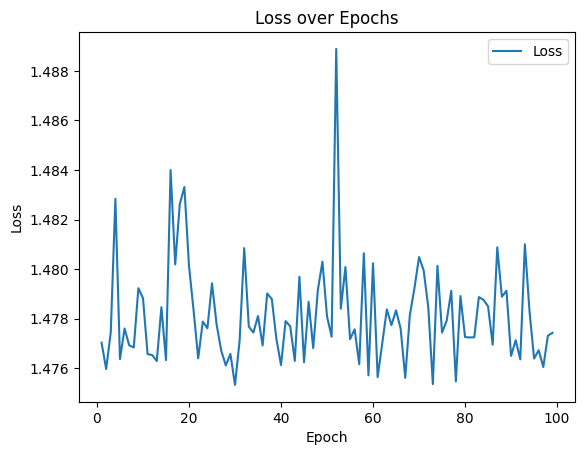

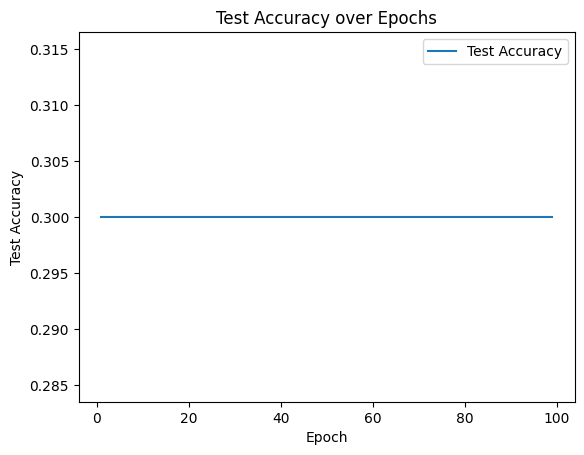

In [13]:
import matplotlib.pyplot as plt

epochs = [epoch for epoch, _, _ in stats]
losses = [loss for _, loss, _ in stats]
test_accs = [test_acc for _, _, test_acc in stats]

# Plot loss
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot test accuracy
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

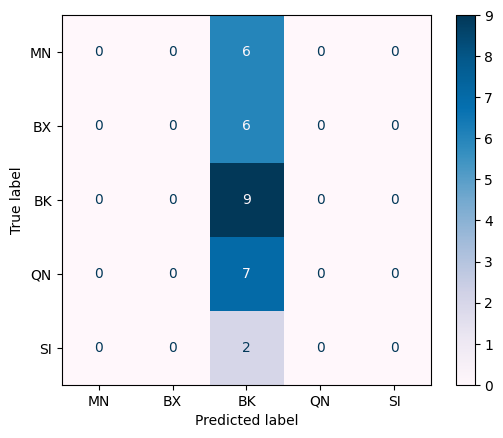

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from matplotlib import pyplot as plt

classes = ["MN", "BX", "BK", "QN", "SI"]

# Create  confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes) 
disp.plot(cmap='PuBu')
plt.show()